---
<h1><center> BrainStation Capstone - EDA</center></h1>

--- 

# Packages Used:

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns
import plotly
import plotly.plotly as py
from plotly import offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True) # offline mode

# ScatterText 
!pip install --upgrade scattertext
import sys
import scattertext as st
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import spacy
!python -m spacy download en

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Populating the interactive namespace from numpy and matplotlib


Requirement already up-to-date: scattertext in /usr/local/lib/python3.6/dist-packages (0.0.2.43)



    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



# Data

From Kaggle Yelp dataset or from Yelp themselves: https://www.yelp.ca/dataset/documentation/main

However, the submission contains the cleaned data, which only contains Toronto restaurants.

In [0]:
# For Google Drive, mounting your local hard drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# The file paths
data_path = '/content/drive/My Drive/BrainStation/Data Science FT/7 - Capstone/Data/'
model_path = '/content/drive/My Drive/BrainStation/Data Science FT/7 - Capstone/Model/'

In [0]:
TO_restaurant = pd.read_csv(data_path+"TO_restaurant.csv")
TO_review = pd.read_csv(data_path+"TO_review.csv")
TO_user = pd.read_csv(data_path+"TO_user.csv")

In [0]:
# Print the shapes of each dataframe
print(f'Restaurant: {TO_restaurant.shape}')
print(f'Review: {TO_review.shape}')
print(f'User: {TO_user.shape}')

Restaurant: (7965, 51)
Review: (376593, 11)
User: (88436, 23)


In [0]:
# Print the columns of each dataframe
print(f'Restaurant: {TO_restaurant.columns}')
print(f'Review: {TO_review.columns}')
print(f'User: {TO_user.columns}')

Restaurant: Index(['name', 'city', 'state', 'country', 'restaurants_star', 'address',
       'is_open', 'latitude', 'longitude', 'categories', 'business_id',
       'postal_code', 'review_count', 'hours - Thursday', 'hours - Friday',
       'hours - Wednesday', 'hours - Tuesday', 'hours - Monday',
       'hours - Saturday', 'hours - Sunday',
       'attributes - BusinessAcceptsCreditCards',
       'attributes - RestaurantsPriceRange2', 'attributes - BusinessParking',
       'attributes - BikeParking', 'attributes - GoodForKids',
       'attributes - RestaurantsTakeOut', 'attributes - OutdoorSeating',
       'attributes - RestaurantsGoodForGroups',
       'attributes - RestaurantsDelivery',
       'attributes - RestaurantsReservations', 'attributes - WiFi',
       'attributes - RestaurantsAttire', 'attributes - Alcohol',
       'attributes - HasTV', 'attributes - Ambience',
       'attributes - NoiseLevel', 'attributes - GoodForMeal',
       'attributes - WheelchairAccessible',
       '

In [0]:
# Add sentiment to the review data based on the star rating
# 1 and 2 are negative
# 3 and 4 are neutral
# 5 is positive
TO_review["sentiment"] = "Positive"
TO_review["sentiment"][TO_review["review_stars"] == 1] = "Negative"
TO_review["sentiment"][TO_review["review_stars"] == 2] = "Negative"
TO_review["sentiment"][TO_review["review_stars"] == 3] = "Neutral"
TO_review["sentiment"][TO_review["review_stars"] == 4] = "Neutral"

In [0]:
# Drop the reviews with 3 and 4 stars since it's quite ambiguous
is_positive = TO_review[TO_review["sentiment"] == "Positive"]
is_negative = TO_review[TO_review["sentiment"] == "Negative"]
filtered = is_positive.append(is_negative)
filtered.reset_index(inplace = True, drop = True)

In [0]:
filtered["review_stars"].value_counts()

5.0    110554
2.0     39160
1.0     36712
Name: review_stars, dtype: int64

# Exploratory Data Analysis

## Text Length Distribution

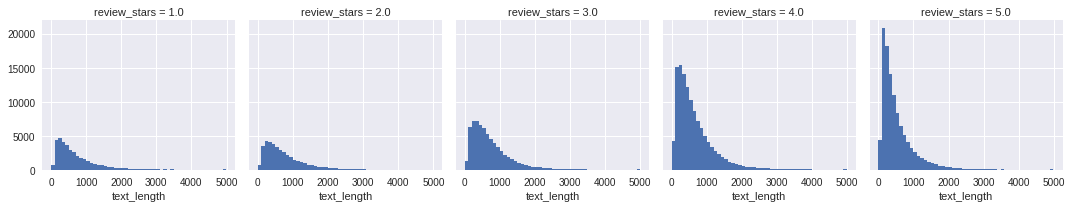

In [0]:
# Evaluate the text length
TO_review['text_length'] = TO_review['text'].apply(len)
g = sns.FacetGrid(data=TO_review, col='review_stars')
g.map(plt.hist, 'text_length', bins=50, )

In [0]:
# Filter out any reviews that have less than 50 characters
TO_review = TO_review[TO_review.text_length > 50]

## Word Count Distributions

In [0]:
# Using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(TO_review.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:
# Create the fine-grained matrix 
neg_matrix = cvec.transform(TO_review[TO_review.review_stars == 1.0].text)
som_neg_matrix = cvec.transform(TO_review[TO_review.review_stars == 2.0].text)
neu_matrix = cvec.transform(TO_review[TO_review.review_stars == 3.0].text)
som_pos_matrix = cvec.transform(TO_review[TO_review.review_stars == 4.0].text)
pos_matrix = cvec.transform(TO_review[TO_review.review_stars == 5.0].text)

neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])

neg_tf_df = neg_tf.set_index('Terms')

som_neg_words = som_neg_matrix.sum(axis=0)
som_neg_words_freq = [(word, som_neg_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
som_neg_tf = pd.DataFrame(list(sorted(som_neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','some-negative'])
som_neg_tf_df = som_neg_tf.set_index('Terms')

neu_words = neu_matrix.sum(axis=0)
neu_words_freq = [(word, neu_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
neu_words_tf = pd.DataFrame(list(sorted(neu_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','neutral'])
neu_words_tf_df = neu_words_tf.set_index('Terms')

som_pos_words = som_pos_matrix.sum(axis=0)
som_pos_words_freq = [(word, som_pos_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
som_pos_words_tf = pd.DataFrame(list(sorted(som_pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','some-positive'])
som_pos_words_tf_df = som_pos_words_tf.set_index('Terms')

pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
pos_words_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
pos_words_tf_df = pos_words_tf.set_index('Terms')

term_freq_df = pd.concat([neg_tf_df,som_neg_tf_df,neu_words_tf_df,som_pos_words_tf_df,pos_words_tf_df],axis=1)

term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['some-negative'] \
                                 + term_freq_df['neutral'] + term_freq_df['some-positive'] \
                                 +  term_freq_df['positive'] 
        
term_freq_df.sort_values(by='total', ascending=False).head(15)

,negative,some-negative,neutral,some-positive,positive,total
food,36934,39805,58519,88852,75547,299657
good,12800,25061,60344,97426,53539,249170
place,22052,24887,44696,78766,67650,238051
great,4755,9757,23597,65465,60587,164161
like,18088,22383,36585,51609,32805,161470
service,19718,20343,30641,46693,39506,156901
just,18150,21653,31905,41484,31183,144375
really,9069,15723,29025,49055,32097,134969
time,14569,14461,22744,38164,29104,119042
restaurant,14191,12833,20484,32348,26595,106451


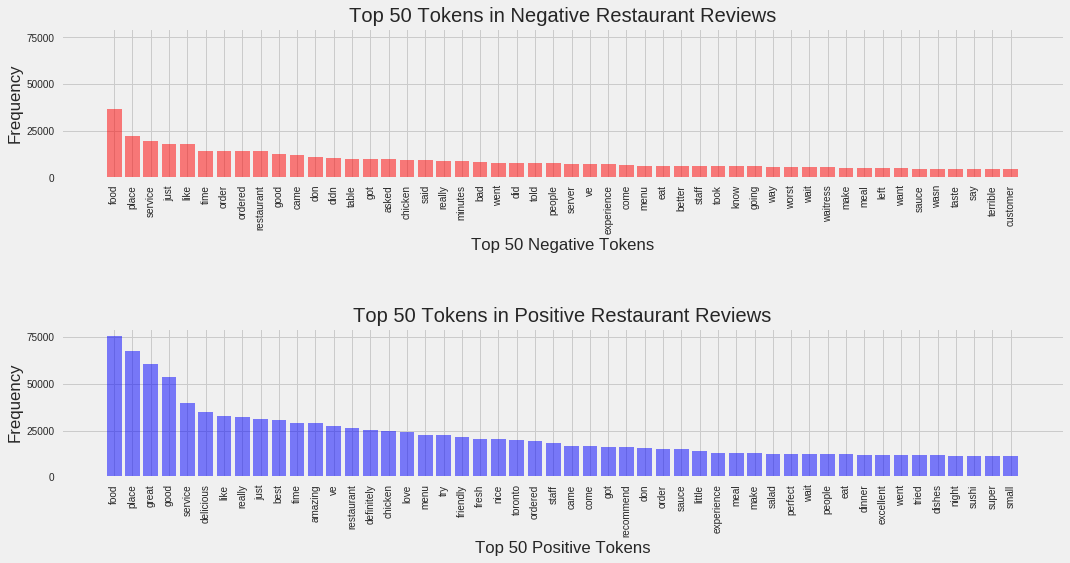

In [0]:
plt.style.use('fivethirtyeight')
y_pos = np.arange(50)
plt.figure(figsize=(16,16))
plt.subplot(211)
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], 
        align='center', alpha=0.5, color = 'r')
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,
           rotation='vertical')
plt.ylim(0,80000)
plt.yticks((0,25000,50000,75000))
plt.ylabel('Frequency')
plt.xlabel('Top 50 Negative Tokens')
plt.title('Top 50 Tokens in Negative Restaurant Reviews')
plt.style.use('fivethirtyeight')


y_pos = np.arange(50)
plt.subplot(212)
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], 
        align='center', alpha=0.5, color = 'b')
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,
           rotation='vertical')
plt.ylim(0,80000)
plt.yticks((0,25000,50000,75000))
plt.ylabel('Frequency')
plt.xlabel('Top 50 Positive Tokens')
plt.title('Top 50 Tokens in Positive Restaurant Reviews')
plt.subplots_adjust(top = 0.4, bottom=0.01, hspace=1., wspace=0.2)
plt.show()

## Scatter Text

In [0]:
# Select only 1000 top positive and 1000 top negative reviews
filtered_1000 = filtered[filtered["sentiment"]=="Positive"].sample(1000).append(filtered[filtered["sentiment"]=="Negative"].sample(1000))
filtered_1000.reset_index(inplace = True, drop = True)

In [0]:
'''
# This is the code to produce the scatter text figures, commented out because it'll take forever to run

# Turn it into a Scattertext Corpus 
nlp = spacy.load('en')
corpus = st.CorpusFromPandas(filtered_1000, category_col='sentiment', text_col='text', nlp=nlp).build()

html = st.produce_scattertext_explorer(corpus, category = "Positive", category_name = 'Good Reviews',
                                       not_category_name = 'Bad Reviews', metadata = filtered_1000['review_stars'])
file_name = "/content/drive/My Drive/BrainStation/Data Science FT/7 - Capstone/TO_reviews_scatter.html"
open(file_name, 'wb').write(html.encode('utf-8'))
'''

'\n# This is the code to produce the scatter text figures, commented out because it\'ll take forever to run\n\n# Turn it into a Scattertext Corpus \nnlp = spacy.load(\'en\')\ncorpus = st.CorpusFromPandas(filtered_1000, category_col=\'sentiment\', text_col=\'text\', nlp=nlp).build()\n\nhtml = st.produce_scattertext_explorer(corpus, category = "Positive", category_name = \'Good Reviews\',\n                                       not_category_name = \'Bad Reviews\', metadata = filtered_1000[\'review_stars\'])\nfile_name = "/content/drive/My Drive/BrainStation/Data Science FT/7 - Capstone/TO_reviews_scatter.html"\nopen(file_name, \'wb\').write(html.encode(\'utf-8\'))\n'

# Logistic Regression Model

In [0]:
# Set up y-labels for binary classification
labels = filtered['review_stars'].map(lambda x : 1 if int(x) > 4 else 0)

# Split the data into train and test data for binary classification 
X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(filtered.text, 
                                                    labels, test_size=0.2, random_state=123)

## Count Vectorizer and TF-IDF

In [0]:
# Build Bag-Of-Words on train review texts

cv = CountVectorizer(stop_words='english',max_features=10000)
cv_train_binary = cv.fit_transform(X_train_binary)


# Build TFIDF features on train review texts

tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_binary = tv.fit_transform(X_train_binary)

# Transform test reviews into features
cv_test_binary = cv.transform(X_test_binary)
tv_test_binary = tv.transform(X_test_binary)

## Evaluation Metrics Function

In [0]:
# Define the evaluation metrics function

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

## Model

In [0]:
# Define the model
lr = LogisticRegression(penalty='l2', max_iter=100, C=1)

In [0]:
# Logistic Regression model on TF-IDF features
lr_tfidf_binary = train_predict_model(classifier=lr,
                                           train_features=tv_train_binary, 
                                           train_labels=Y_train_binary,
                                           test_features=tv_test_binary, 
                                           test_labels=Y_test_binary)
display_model_performance_metrics(true_labels=Y_test_binary, 
                                  predicted_labels=lr_tfidf_binary,
                                  classes=[0,1.0])

Model Performance metrics:
------------------------------
Accuracy: 0.9721
Precision: 0.972
Recall: 0.9721
F1 Score: 0.972

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     15209
         1.0       0.97      0.98      0.98     22077

   micro avg       0.97      0.97      0.97     37286
   macro avg       0.97      0.97      0.97     37286
weighted avg       0.97      0.97      0.97     37286


Prediction Confusion Matrix:
------------------------------
            Predicted:       
                   0.0    1.0
Actual: 0.0      14635    574
        1.0        468  21609
